## Super-resolve output

In [25]:
from __future__ import print_function
import argparse
import torch
import torch.backends.cudnn as cudnn
from PIL import Image

from torchvision.transforms import ToTensor
#from skimage.metrics import peak_signal_noise_ratio as psnr
#from skimage.metrics import structural_similarity as ssim

from skimage.measure import compare_psnr as psnr
from skimage.measure import compare_ssim as ssim

import numpy as np
import matplotlib.pyplot as plt
from super_resolution_data_loader_GAN import display_transform
import torchvision.utils as utils

In [2]:
# Path to data

low_res_img_path = '../dataset/300W-3D-crap-56/test/AFW_37096733_1.jpg'
original_img_path = '../dataset/300W-3D-low-res-22/test/AFW_37096733_1.jpg'

#low_res_img_path = '/media/angelo/DATEN/Datasets/Experiment_Masters/300W-3D-crap-112/test/AFW_37096733_1.jpg'
#original_img_path = '/media/angelo/DATEN/Datasets/Experiment_Masters/300W-3D-low-res-224/test/AFW_37096733_1.jpg'

model_path_1 = 'netG_epoch_4_5.pth'
model_path_2 = 'netG_epoch_4_10.pth'

In [26]:
# Input Image Setting

GPU_IN_USE = torch.cuda.is_available()
#img = Image.open(low_res_img_path).convert('YCbCr')
#y, cb, cr = img.split()
img = Image.open(low_res_img_path)

In [27]:
from SRGAN_model import Generator

device = torch.device('cuda' if GPU_IN_USE else 'cpu')

model = Generator(4).to(device)
model.load_state_dict(torch.load(model_path_1))
model = model.to(device)
model.eval()

Generator(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): ResidualBlock(
    (conv1)

In [28]:
# Input image setting

#device = torch.device('cuda' if GPU_IN_USE else 'cpu')
#model = torch.load(model_path_1, map_location=lambda storage, loc: storage)
#model = model.to(device)
#data = (ToTensor()(y)).view(1, -1, y.size[1], y.size[0])
data = (ToTensor()(img)).view(1, 3, img.size[1], img.size[0])
data = data.to(device)

if GPU_IN_USE:
    cudnn.benchmark = True

In [29]:
out = model(data)
out = out.data.cpu().squeeze(0)
#out *= 255.0
#out = out.clip(0, 255).astype(int)
#out = out.reshape((out.shape[1], out.shape[2], out.shape[0]))

test_image = torch.stack([out])
image = utils.make_grid(test_image, nrow=1, padding=5)
utils.save_image(image, 'srgan_img_5epochs.png', padding=5)

#plt.imshow(out)

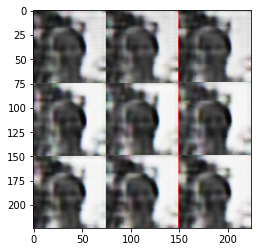

In [20]:
out = model(data)
out = out.cpu()
out = out.squeeze(0).detach().numpy()
out *= 255.0
out = out.clip(0, 255).astype(int)
out = out.reshape((out.shape[1], out.shape[2], out.shape[0]))

plt.imshow(out)

In [5]:
# Output and save image

out = model(data)
out = out.cpu()
out_img_y = out.data[0].numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')

#out_img.save('result.png')

In [6]:
# Checking image quality

real_img = Image.open(original_img_path)
bicubic_img = img.resize((224,224),resample=Image.BICUBIC)

# PSNR and SSIM - Bilinear Interpolation

print('PSNR and SSIM BICUBIC: %.3f and %.3f' %(psnr(np.array(bicubic_img), np.array(real_img)), 
                                               ssim(np.array(bicubic_img), np.array(real_img), multichannel=True)))
print('PSNR and SSIM MODEL:   %.3f and %.3f' %(psnr(np.array(out_img), np.array(real_img)), 
                                               ssim(np.array(out_img), np.array(real_img), multichannel=True)))

plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.gca().set_title('Low Res')
plt.imshow(img)
plt.subplot(1,4,2)
plt.gca().set_title('Bicubic')
plt.imshow(bicubic_img)
plt.subplot(1,4,3)
plt.gca().set_title('Neural Net')
plt.imshow(out_img)
plt.subplot(1,4,4)
plt.gca().set_title('Original')
plt.imshow(real_img)
plt.show()

PSNR and SSIM BICUBIC: 10.850 and 0.441


ValueError: Input images must have the same dimensions.